In [192]:
import numpy as np
import getdist
from getdist import plots
import matplotlib.pyplot as plt
import matplotlib
import os
import scipy
import random
%matplotlib inline

import getdist.plots as gplot
from getdist import MCSamples
from getdist import loadMCSamples

import tensiometer as ten
from tensiometer import gaussian_tension
from tensiometer import mcmc_tension
from tensiometer import utilities as utils

# GENERAL PLOT OPTIONS
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rcParams['mathtext.rm'] = 'Bitstream Vera Sans'
matplotlib.rcParams['mathtext.it'] = 'Bitstream Vera Sans:italic'
matplotlib.rcParams['mathtext.bf'] = 'Bitstream Vera Sans:bold'
matplotlib.rcParams['xtick.bottom'] = True
matplotlib.rcParams['xtick.top'] = False
matplotlib.rcParams['ytick.right'] = False
matplotlib.rcParams['axes.edgecolor'] = 'black'
matplotlib.rcParams['axes.linewidth'] = '1.0'
matplotlib.rcParams['axes.labelsize'] = 'medium'
matplotlib.rcParams['axes.grid'] = True
matplotlib.rcParams['grid.linewidth'] = '0.0'
matplotlib.rcParams['grid.alpha'] = '0.18'
matplotlib.rcParams['grid.color'] = 'lightgray'
matplotlib.rcParams['legend.labelspacing'] = 0.77
matplotlib.rcParams['savefig.bbox'] = 'tight'
matplotlib.rcParams['savefig.format'] = 'pdf'

analysissettings={'smooth_scale_1D':0.2,
                  'smooth_scale_2D':0.2,
                  'ignore_rows': u'0.35',
                  'range_confidence' : u'0.005',
                  'fine_bins': 2048,
                  'fine_bins_2D': 1024}

analysissettings2={'smooth_scale_1D':0.25,
                   'smooth_scale_2D':0.25,
                   'ignore_rows': u'0.0',
                   'range_confidence' : u'0.005',
                   'fine_bins': 2048,
                   'fine_bins_2D': 1024}

chaindir = os.environ['ROOTDIR']+'/projects/example/chains/TM/'

Exercise inspired by Berghaus, Kable & Miranda DESI analysis (few differences: low-ell EE Planck 2020, priors not exactly the same...)

# Definitions:

In [186]:
def get_diff_chain(root_chains, 
                   num_points_thin=50000, 
                   print_param_names_diff=False):
    r1 = random.randint(0, 30000);
    # -----------------------------------------------------------------------------
    # SAMPLES1 --------------------------------------------------------------------
    # -----------------------------------------------------------------------------
    i=0
    samples1 = loadMCSamples(chaindir + root_chains[i], settings=analysissettings);
    if num_points_thin > 0:
        samples1.thin(factor = max(int(np.sum(samples1.weights)/num_points_thin),1))
    p = samples1.getParams();
    path = chaindir +  '.tmp1_' + str(r1) + '_' + str(i)
    samples1.saveAsText(path);
    samples1 = loadMCSamples(path, settings=analysissettings2);
    # -----------------------------------------------------------------------------
    # SAMPLES2 --------------------------------------------------------------------
    # -----------------------------------------------------------------------------
    i=1
    samples2 = loadMCSamples(chaindir + root_chains[i], settings=analysissettings);
    if num_points_thin > 0:
        samples2.thin(factor = max(int(np.sum(samples2.weights)/num_points_thin),1))
    p = samples2.getParams();
    path = chaindir +  '.tmp3_' + str(r1) + '_' + str(i)
    samples2.saveAsText(path);
    samples2 = loadMCSamples(path, settings=analysissettings2);
    # -----------------------------------------------------------------------------
    # Diff Chain ------------------------------------------------------------------
    # -----------------------------------------------------------------------------
    diff_chain = mcmc_tension.parameter_diff_chain(samples1, samples2, boost=1)
    if print_param_names_diff == True:
        print(diff_chain.getParamNames())
    # -----------------------------------------------------------------------------
    # TENSION METRIC --------------------------------------------------------------
    # -----------------------------------------------------------------------------
    return (samples1, samples2, diff_chain);

In [194]:
def get_udm_tension(root_chains, 
                    num_points_thin = 50000,
                    lower_cutoff=1.05,
                    param_names = None, 
                    print_param_names_diff=False):
    (samples1, samples2, diff_chain) = get_diff_chain(root_chains=root_chains, 
                                                      num_points_thin=num_points_thin, 
                                                      print_param_names_diff=print_param_names_diff)    
    # -----------------------------------------------------------------------------
    # Tension Computation ---------------------------------------------------------
    # -----------------------------------------------------------------------------
    Q_UDM, Q_UDM_dofs = gaussian_tension.Q_UDM(samples1, samples2, param_names=param_names, lower_cutoff=lower_cutoff)
    Q_UDM_P = scipy.stats.chi2.cdf(Q_UDM, Q_UDM_dofs)
    Q_UDM_nsigma = utils.stats_utilities.from_confidence_to_sigma(Q_UDM_P)
    return Q_UDM_nsigma

In [183]:
def get_ng_tension(root_chains, 
                   num_points_thin=50000, 
                   param_names=None, 
                   feedback=1,
                   print_param_names_diff=False):
    (samples1, samples2, diff_chain) = get_diff_chain(root_chains=root_chains, 
                                                      num_points_thin=num_points_thin,
                                                      print_param_names_diff=print_param_names_diff)
    # -----------------------------------------------------------------------------
    # TENSION METRIC --------------------------------------------------------------
    # -----------------------------------------------------------------------------
    shift_P, shift_P_low, shift_P_hi = mcmc_tension.kde_parameter_shift(diff_chain, 
                                                                        feedback=feedback,
                                                                        param_names=param_names);
    return utils.stats_utilities.from_confidence_to_sigma(shift_P);

# CALCULATE UDM TENSION METRIC

In [199]:
root_chains = (
  'PANTHEON/EXAMPLE_EMUL_MCMC1',     # CMB + SN (Pantheon) + BAO (DESI-Y2)
  'PANTHEONPLUS/EXAMPLE_EMUL_MCMC1', # CMB + SN (pantheonplus) + BAO (DESI-Y2)
  'DESY5/EXAMPLE_EMUL_MCMC1',        # CMB + SN (desy5) + BAO (DESI-Y2)
  'UNION3/EXAMPLE_EMUL_MCMC1'        # CMB + SN (union3) + BAO (DESI-Y2)
)
answer = [0] * len(root_chains)
for i in range(len(root_chains)):
    answer[i] = get_udm_tension(root_chains = ('EXAMPLE_EMUL_MCMC1', root_chains[i]), 
                                param_names=['H0','omegam'], 
                                num_points_thin=20000)
print('\nFinal result for LCDM (UDM) Tension Metric (BAO = DESI-Y2): ', answer)


Final result for LCDM (UDM) Tension Metric (BAO = DESI-Y2):  [nan, nan, 2.391633145581253, nan]


In [200]:
root_chains = (
  'PANTHEON/EXAMPLE_EMUL_MCMC2',     # CMB + SN (Pantheon) + BAO (DESI-Y1)
  'PANTHEONPLUS/EXAMPLE_EMUL_MCMC2', # CMB + SN (pantheonplus) + BAO (DESI-Y1)
  'DESY5/EXAMPLE_EMUL_MCMC2',        # CMB + SN (desy5) + BAO (DESI-Y1)
  'UNION3/EXAMPLE_EMUL_MCMC2'        # CMB + SN (union3) + BAO (DESI-Y1)
)
answer = [0] * len(root_chains)
for i in range(len(root_chains)):
    answer[i] = get_udm_tension(root_chains = ('EXAMPLE_EMUL_MCMC2', root_chains[i]), 
                                num_points_thin=20000, param_names=['H0','omegam'])
print('\nFinal result for LCDM (UDM) Tension Metric (BAO = DESI-Y1): ', answer)


Final result for LCDM (UDM) Tension Metric (BAO = DESI-Y1):  [0.03581632794927345, 1.6192705284274929, 2.1054398335041733, 1.2072865762880047]


# CALCULATE NG TENSION METRIC

In [37]:
root_chains = (
  'PANTHEON/EXAMPLE_EMUL_MCMC3',       # SN (Pantheon)
  'PANTHEONPLUS/EXAMPLE_EMUL_MCMC3',   # SN (pantheonplus) 
  'DESY5/EXAMPLE_EMUL_MCMC3',          # SN (desy5) 
  'UNION3/EXAMPLE_EMUL_MCMC3'          # SN (union3) 
)
param_names = ('delta_H0','delta_omegam')
answer = [0] * len(root_chains)
for i in range(len(root_chains)):
    root = ('EXAMPLE_EMUL_MCMC1', root_chains[i])
    answer[i] = get_ng_tension(root_chains=root, num_points_thin=20000, feedback=0, param_names=param_names)
print('\nFinal result for LCDM (NG) Tension Metric (BAO = DESI-Y3): ',answer)


Final result for LCDM (NG) Tension Metric (BAO = DESI-Y3):  [0.686678173149576, 2.0011034908240544, 2.8518456702656474, 2.172596563451351]


In [38]:
root_chains = (
  'PANTHEON/EXAMPLE_EMUL_MCMC3',       # SN (Pantheon)
  'PANTHEONPLUS/EXAMPLE_EMUL_MCMC3',   # SN (pantheonplus) 
  'DESY5/EXAMPLE_EMUL_MCMC3',          # SN (desy5) 
  'UNION3/EXAMPLE_EMUL_MCMC3'          # SN (union3) 
)
param_names = ('delta_H0','delta_omegam')
answer = [0] * len(root_chains)
for i in range(len(root_chains)):
    root = ('EXAMPLE_EMUL_MCMC2', root_chains[i])
    answer[i] = get_ng_tension(root_chains=root, num_points_thin=20000, feedback=0, param_names=param_names)
print('\nFinal result for LCDM (NG) Tension Metric (BAO = DESI-Y1): ',answer)


Final result for LCDM (NG) Tension Metric (BAO = DESI-Y1):  [0.7153085302539712, 1.8656438490569407, 2.8289359646118952, 2.074248844084374]


# Load all chains (for Plotting)

In [15]:
root_chains = (
  'PANTHEON/EXAMPLE_EMUL_MCMC3',       # SN (Pantheon) + BAO (DESI-Y3)
  'PANTHEONPLUS/EXAMPLE_EMUL_MCMC3',   # SN (pantheonplus) + BAO (DESI-Y3)
  'DESY5/EXAMPLE_EMUL_MCMC3',          # SN (desy5) + BAO (DESI-Y3)
  'UNION3/EXAMPLE_EMUL_MCMC3'          # SN (union3) + BAO (DESI-Y3)
)
samples1v1 = [0] * len(root_chains)
samples2 = [0] * len(root_chains)
diffchainv1 = [0] * len(root_chains)
for i in range(len(root_chains)):
    root = (root_chains[i], 'EXAMPLE_EMUL_MCMC1')
    (samples1v1[i], samples2[i], diffchainv1[i]) = get_diff_chain(root_chains=root, num_points_thin=50000)

samples1v2 = [0] * len(root_chains)
samples2 = [0] * len(root_chains)
diffchainv2 = [0] * len(root_chains)
for i in range(len(root_chains)):
    root = (root_chains[i], 'EXAMPLE_EMUL_MCMC2')
    (samples1v2[i], samples2[i], diffchainv2[i]) = get_diff_chain(root_chains=root, num_points_thin=50000)

# PLOT 1D $\Delta \Omega_m$

[]

<Figure size 800x600 with 0 Axes>

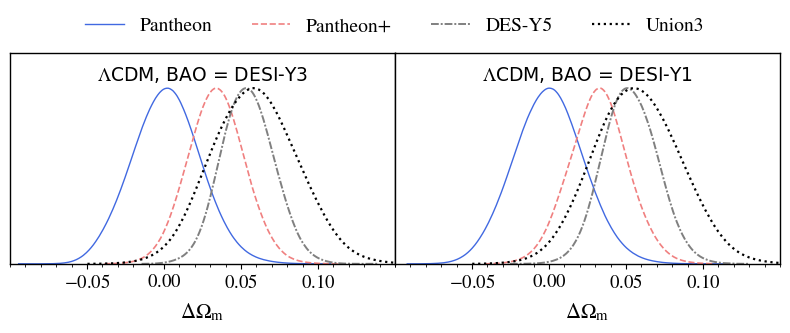

In [90]:
g = plots.get_single_plotter(width_inch=8.0, ratio=0.75)
g.settings.lw_contour = 1.2
g.settings.legend_rect_border = False
g.settings.figure_legend_frame = False
g.settings.axes_fontsize = 13.5
g.settings.legend_fontsize = 14.
g.settings.alpha_filled_add = 0.7
g.settings.lab_fontsize=15
g.legend_labels=False
g.settings.tight_layout=True

g.vmplots_1d(
    roots=[
        [
            diffchainv1[0],
            diffchainv1[1],
            diffchainv1[2],
            diffchainv1[3],
        ],
        [
            diffchainv2[0],
            diffchainv2[1],
            diffchainv2[2],
            diffchainv2[3],
        ],
     ],
    roots_per_param=True,
    nx=2,
    share_y=True,
    params=[u'delta_omegam',u'delta_omegam'],
    plot_3d_with_param=None,
    line_args=[
        {'lw': 1.0,'ls': 'solid', 'color':'royalblue'},
        {'lw': 1.2,'ls': 'dashed', 'color':'lightcoral'},
        {'lw': 1.4,'ls': '-.', 'color':'grey'},
        {'lw': 1.6,'ls': 'dotted', 'color':'black'},
        {'lw': 1.0,'ls': 'dashdot', 'color':'purple'}
    ],
    do_xlabel=True,
    vmmessage=[
      '$\Lambda$CDM, BAO = DESI-Y3',
      '$\Lambda$CDM, BAO = DESI-Y1'
    ],
    vmmessage_size=13.5,
    xlims=[[-0.1,0.15],[-0.1,0.15]],
)

g.settings.tight_layout=True
g.finish_plot(
    legend_labels=[
      'Pantheon', 
      'Pantheon+', 
      'DES-Y5', 
      'Union3' 
    ],
    legend_ncol=4,
)

ax = g.subplots
ax[0,0].minorticks_on()
ax[0,0].set_yticks([], minor=False)
ax[0,0].set_yticks([], minor=True)
# ----------------------------------------------------
ax[0,1].minorticks_on()
ax[0,1].set_yticks([], minor=False)
ax[0,1].set_yticks([], minor=True)
# ----------------------------------------------------

# PLOT Triangle diff

# Plot Triangle

In [173]:
from getdist import MCSamples
asettings = {'smooth_scale_1D':0.2,
             'smooth_scale_2D':0.2,
             'ignore_rows': u'0.35',
             'range_confidence' : u'0.01',
             'fine_bins': 2048,
             'fine_bins_2D': 1024}
samples = [loadMCSamples(file_root=chaindir+'PANTHEON/EXAMPLE_EMUL_MCMC1', settings=asettings),
           loadMCSamples(file_root=chaindir+'PANTHEONPLUS/EXAMPLE_EMUL_MCMC1', settings=asettings),
           loadMCSamples(file_root=chaindir+'DESY5/EXAMPLE_EMUL_MCMC1', settings=asettings),
           loadMCSamples(file_root=chaindir+'UNION3/EXAMPLE_EMUL_MCMC1', settings=asettings)]
stats = [0]*len(samples)
p = [0]*len(samples)
for i in range(len(samples)):
    p[i] = samples[i].getParams()
    print(samples[i].getInlineLatex("chi2__SN", limit=1))

\chi^2_\mathrm{SN} = 1034.776\pm 0.044
\chi^2_\mathrm{SN} = 1406.21\pm 0.79
\chi^2_\mathrm{SN} = 1649.9\pm 1.5
\chi^2_\mathrm{SN} = 28.76\pm 0.69


In [174]:
samples[0].addDerived(p[0].chi2__SN-1034.77,name='chi2sn',label='{\\chi^2_{\\rm SN}}')
samples[1].addDerived(p[1].chi2__SN-1406.21,name='chi2sn',label='{\\chi^2_{\\rm SN}}')
samples[2].addDerived(p[2].chi2__SN-1649.9,name='chi2sn',label='{\\chi^2_{\\rm SN}}')
samples[3].addDerived(p[3].chi2__SN-28.76,name='chi2sn',label='{\\chi^2_{\\rm SN}}')

<Figure size 650x487.5 with 0 Axes>

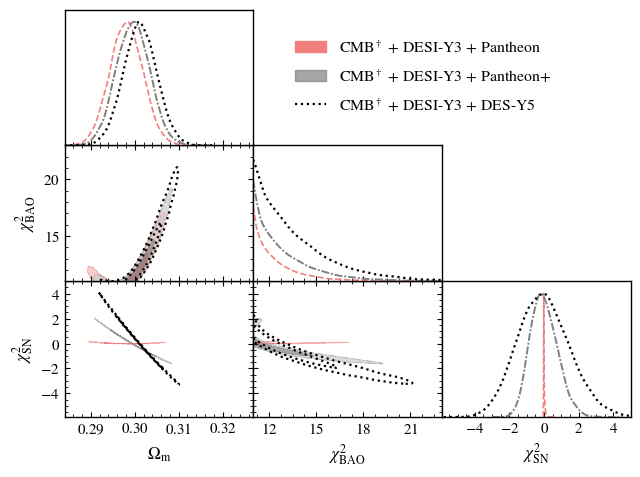

In [177]:
from getdist import MCSamples

g = gplot.get_single_plotter(width_inch=6.5)

g.settings.lw_contour = 1.2
g.settings.legend_rect_border = False
g.settings.figure_legend_frame = False
g.settings.axes_fontsize = 13.5
g.settings.legend_fontsize = 14.
g.settings.alpha_filled_add = 0.7
g.settings.lab_fontsize=15
g.legend_labels=False
g.settings.tight_layout=True


g.triangle_plot(
  roots= [
    samples[0],    
    samples[1], 
    samples[2]
  ],
  params=['omegam', 'chi2__BAO', 'chi2sn'],
  line_args=[
    {'lw': 1.2,'ls': 'dashed', 'color':'royalblue'},
    {'lw': 1.4,'ls': '-.', 'color':'lightcoral'},
    {'lw': 1.6,'ls': 'dotted', 'color':'black'},
    {'lw': 1.0,'ls': 'dashdot', 'color':'purple'}
  ],
  contour_colors=['royalblue','lightcoral','black', 'purple'],
  filled=[True,True,False,False],
  contour_ls=['dashed', '-.', 'dotted', 'dashdot'],
  contour_lws=[1.2, 1.4, 1.6, 1.0],
  legend_labels=[
   '${\\rm CMB}^\dagger$ + DESI-Y3 + Pantheon', 
   '${\\rm CMB}^\dagger$ + DESI-Y3 + Pantheon+', 
   '${\\rm CMB}^\dagger$ + DESI-Y3 + DES-Y5'
  ],
  legend_loc=(0.45,0.75))

# ----------------------------------------------------
# ----------------------------------------------------
axarr = g.subplots
# ----------------------------------------------------
axarr[2,0].set_xlim([0.284,0.327])
axarr[2,0].set_xticks([0.29,0.30,0.31,0.32], minor=False)
axarr[2,0].set_yticks([-4,-2,0,2,4], minor=False)
axarr[2,0].minorticks_on()
# ----------------------------------------------------
axarr[2,1].set_xlim([11,23])
axarr[2,1].set_xticks([12,15,18,21], minor=False)
axarr[2,1].minorticks_on()
# ----------------------------------------------------
axarr[2,2].set_xlim([-5.9,5])
axarr[2,2].set_xticks([-4,-2.0,0,2.0,4.0], minor=False)
axarr[2,2].set_yticks([], minor=False)
axarr[2,2].set_yticks([], minor=True)
axarr[2,2].minorticks_on()
# ----------------------------------------------------
axarr[1,0].minorticks_on()